<a href="https://colab.research.google.com/github/JoshMcConkie/control-lab/blob/main/maglev/notebooks/MagLevBall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from scipy.optimize import differential_evolution
from functools import partial

### Original PID

In [ ]:

# def mag_lev_pid(Kp = 1.0, Ki = 0.0, Kd = 0.0):

#     # Constants
#     BALL_MASS = .01
#     GRAVITY = -9.8
#     Y_GOAL = -.10
#     Y_INIT = -.12
#     MAGNET_CONSTANT = 9.8E-4
#     AMP_MAX = 100.0
#     AMP_INIT = 10
#     TIME_STEP = 0.01
#     TIME_WINDOW = 1.0

#     MAG_RESISTANCE = 5

#     amperage = AMP_INIT

#     y = Y_INIT
#     y_error_sum = 0.0
#     y_error_lag = Y_GOAL-y
#     velocity = 0

#     tot_energy = 0.0
#     time_hist = []
#     error_hist = []
#     amperage_hist = []
#     y_hist = []
#     velocity_hist = []
#     acceleration_hist = []

#     for t in range(int(TIME_WINDOW/TIME_STEP)):

#         # print(f'Position: {y}')

#         time = t * TIME_STEP
#         y_error = Y_GOAL - y
#         y_error_sum += y_error

#         #PID
#         amperage = Kp*y_error+Ki*y_error_sum+Kd*(y_error-y_error_lag)/TIME_STEP
#         amperage = min(amperage, AMP_MAX)
#         amperage = max(amperage, 0)
#         mag_force = MAGNET_CONSTANT * amperage**2 / y**2
#         acceleration = mag_force/BALL_MASS + GRAVITY
#         # print(f'Amperage: {amperage}, Acceleration: {acceleration}')
#         velocity += acceleration * TIME_STEP
#         y += velocity * TIME_STEP

#         y_error_lag = y_error
#         tot_energy += amperage**2 * TIME_STEP


#         time_hist.append(t*TIME_STEP)
#         error_hist.append(y_error)
#         amperage_hist.append(amperage)
#         y_hist.append(y)
#         velocity_hist.append(velocity)
#         acceleration_hist.append(acceleration)

#     print(f'Total Energy: {tot_energy:.2f} Joules')


#     plt.figure(figsize=(12, 12))

#     # 1. Height
#     plt.subplot(5, 1, 1)
#     plt.plot(time_hist, y_hist, label="Height")
#     plt.axhline(-0.1, color='gray', linestyle='--', label="Goal Height")
#     plt.ylabel("Height (m)")
#     plt.legend()

#     # 2. Velocity
#     plt.subplot(5, 1, 2)
#     plt.plot(time_hist, velocity_hist, label="Velocity", color='green')
#     plt.ylabel("Velocity (m/s)")
#     plt.legend()

#     # 3. Acceleration
#     plt.subplot(5, 1, 3)
#     plt.plot(time_hist, acceleration_hist, label="Acceleration", color='purple')
#     plt.ylabel("Acceleration (m/s²)")
#     plt.legend()

#     # 4. Amperage
#     plt.subplot(5, 1, 4)
#     plt.plot(time_hist, amperage_hist, label="Amperage", color='orange')
#     plt.ylabel("Amperage (A)")
#     plt.legend()

#     # 5. y_error
#     plt.subplot(5, 1, 5)
#     plt.plot(time_hist, error_hist, label="y_error", color='red')
#     plt.xlabel("Time (s)")
#     plt.ylabel("y_error")
#     plt.legend()


#     plt.tight_layout()
#     plt.show()

# interact(mag_lev_pid,
#   Kp=FloatSlider(value=50.0, min=0.0, max=100, step=0.1, description='Kp'),
#   Ki=FloatSlider(value=0.50, min=0.0, max=8, step=0.1, description='Ki'),
#   Kd=FloatSlider(value=10.0, min=0.0, max=20, step=0.1, description='Kd')
# )


### Constants

In [8]:
# Constants
BALL_MASS = .01
GRAVITY = -9.8

V_INIT = 0

Y_GOAL = -0.0254 # 1 inch below magnet
Y_INIT = -0.0254*2  # starts 2 inches below magnet
tol = .05 * abs(Y_GOAL)
TIME_STEP = 0.01
TIME_WINDOW = 1.0
times = np.arange(0, TIME_WINDOW + TIME_STEP/2, TIME_STEP)

POWER_GOAL = 1 #Joules

MAGNET_CONSTANT = 9.8E-4
MAG_RESISTANCE = 5 #ohms

AMP_MAX = 2.0
AMP_INIT = 0
# below is amps need to equalize gravity at desired distance from mag
amperage_hover = np.sqrt(abs(Y_GOAL)**2*BALL_MASS*abs(GRAVITY) / MAGNET_CONSTANT)

def cost(K,w_time=6, w_acc=10, w_err=10, w_pow=10, disp=False, fn=None):
    t_to_target, norm_err, norm_acc, norm_pow_cons, tot_pow_cons = fn(K)
    values = [t_to_target, norm_err, norm_acc, norm_pow_cons, tot_pow_cons]
    for x in values:
        if not isinstance(x, (int, float)) or np.isnan(x) or np.isinf(x):
            return 1e60

    time_cost = w_time * t_to_target/TIME_WINDOW/10
    err_cost = w_err * norm_err
    acc_cost = w_acc * norm_acc
    pow_cost = w_pow * norm_pow_cons

    cost = time_cost + err_cost + acc_cost + pow_cost
    if disp:
        data = {
            'Time to Target (s)':   [t_to_target,      w_time, time_cost],
            'RMS y_error':             [norm_err,         w_err,  err_cost],
            'RMS Acceleration':      [norm_acc,         w_acc,  acc_cost],
            'Power Consumption ratio (×)': [norm_pow_cons,    w_pow,  pow_cost]
        }
        df_metrics = pd.DataFrame(data, index=['Value','Weight','Cost'])
        print(df_metrics.round(3).to_string())

        # Optionally print the grand total
        print(f"Total Power Consumption: {tot_pow_cons:.3f} J")
        # print(f"\nTotal Cost: {cost:.3f}")
    return cost


Kp_bounds = (0, 100)
Ki_bounds = (0, 8)
Kd_bounds = (0, 20)
bounds = [Kp_bounds, Ki_bounds, Kd_bounds]

### Cost Minimizing PID

In [ ]:
def run_mag_lev_pid(K, hist=False):
    Kp = K[0]
    Ki = K[1]
    Kd = K[2]

    np.random.seed(42)

    amperage = AMP_INIT
    y = Y_INIT

    y_error_sum = 0.0
    y_error_lag = Y_GOAL-y
    dyde_lag = 0
    velocity = 0
    tot_energy = 0.0
    history = []

    t_to_target = None

    for time in times:
        y_error = Y_GOAL - y

        #Moving Avg Process to smooth things (uneccessary for magnets)
        a = 1
        dyde_raw = (y_error-y_error_lag)/TIME_STEP
        dyde_smooth = a*dyde_raw + (1-a)*dyde_lag

        #PID + feed-forward
        P=Kp * y_error
        I=Ki * y_error_sum
        D=Kd * dyde_smooth

        ampsend_raw = amperage_hover+P+I+D

        #Clamping
        ampsend_clamp = min(max(ampsend_raw,0),AMP_MAX)

        if ampsend_clamp == ampsend_raw:
          y_error_sum += y_error*TIME_STEP
        amperage = ampsend_clamp

        if abs(y) < .01:
            return np.inf, np.inf, np.inf, np.inf, np.inf
              # kill the run immediately

        mag_force = MAGNET_CONSTANT * amperage**2 / y**2
        acceleration = mag_force/BALL_MASS + GRAVITY
        # print(f'Amperage: {amperage}, Acceleration: {acceleration}')
        velocity += acceleration * TIME_STEP
        y += velocity * TIME_STEP

        y_error_lag = y_error
        tot_energy += amperage**2 * TIME_STEP


        dyde_lag = dyde_smooth

        if t_to_target is None:
            if abs(y - Y_GOAL) < tol:
                t_to_target = time
        if np.isnan(y) or np.isnan(amperage) or np.isnan(tot_energy):
            print("Simulation blew up!")
            return np.inf, np.inf, np.inf, np.inf, np.inf
        history.append({
          'time': time,
          'height': y,
          'velocity': velocity,
          'acceleration': acceleration,
          'y_error': y_error,
          'amperage': amperage,
          'total_energy': tot_energy,
    })
    if t_to_target is None:
        return np.inf, np.inf, np.inf, np.inf, np.inf
    df = pd.DataFrame(history)

    post_target_df = df.loc[df['time'] > t_to_target]

    if post_target_df.empty:
        # If no data after target time, assign penalty or a default value
        RMS_error = np.inf # Penalize if the ball only reaches the target at the very end
        norm_err = np.inf
        RMS_acc = 0 # No acceleration after target time if no data exists
        norm_acc = 0
    else:
        RMS_error = np.sqrt(np.mean(post_target_df['y_error']**2))
        norm_err = RMS_error/abs(Y_GOAL)*5

        RMS_acc = np.sqrt(np.mean(post_target_df['acceleration']**2))
        # Check if max acceleration is zero to avoid division by zero
        max_abs_acc = max(abs(post_target_df['acceleration']))
        if max_abs_acc == 0:
            norm_acc = 0
        else:
            norm_acc = RMS_acc/max_abs_acc/10

    tot_pow_cons = max(df['total_energy'])
    norm_pow_cons = tot_pow_cons/POWER_GOAL/100

    if hist:
        plt.figure(figsize=(12, 12))

        # 1. Height
        plt.subplot(5, 1, 1)
        plt.plot(df['time'], df['height'], label="Height")
        plt.axhline(Y_GOAL, color='gray', linestyle='--', label="Goal Height")
        plt.ylabel("Height (m)")
        plt.legend()

        # 2. Velocity
        plt.subplot(5, 1, 2)
        plt.plot(df['time'], df['velocity'], label="Velocity", color='green')
        plt.ylabel("Velocity (m/s)")
        plt.legend()

        # 3. Acceleration
        plt.subplot(5, 1, 3)
        plt.plot(df['time'], df['acceleration'], label="Acceleration", color='purple')
        plt.ylabel("Acceleration (m/s²)")
        plt.legend()

        # 4. Amperage
        plt.subplot(5, 1, 4)
        plt.plot(df['time'], df['amperage'], label="Amperage", color='orange')
        plt.ylabel("Amperage (A)")
        plt.legend()

        # 5. y_error
        plt.subplot(5, 1, 5)
        plt.plot(df['time'], df['y_error'], label="y_error", color='red')
        plt.xlabel("Time (s)")
        plt.ylabel("y_error")
        plt.legend()

        plt.tight_layout()
        plt.show()

    return t_to_target, norm_err, norm_acc, norm_pow_cons, tot_pow_cons

optimized = differential_evolution(
    cost, bounds,
    # disp=True,
    maxiter=1000,         # reduce from default 1000
    popsize=10,         # reduce from default 15
    tol=1e-3,           # slightly looser tolerance
    seed=42
)

print(optimized.x)
# print(optimized.fun)
# print(optimized.success)
print(optimized.message)
print(f"Iterations: {optimized.nit}")
print(f"Evaluations: {optimized.nfev}")

print(cost(optimized.x, disp=True))
run_mag_lev_pid(optimized.x,hist=True)

optimal_K_pred = optimized.x


### 3. Introduce real time position fetching + random shocks

[45.61340959  0.          1.82084197]
   time    height  predicted_height  velocity  acceleration   y_error  \
0  0.00 -0.044203         -0.044203  0.659749     65.974858  0.025400   
1  0.01 -0.038580         -0.038580  0.562215     -9.753407  0.018803   
2  0.02 -0.033938         -0.033938  0.464215     -9.800000  0.013180   
3  0.03 -0.030276         -0.030276  0.366215     -9.800000  0.008538   
4  0.04 -0.027594         -0.027594  0.268215     -9.800000  0.004876   

   amperage  total_energy  
0  1.412581      0.019954  
1  0.030479      0.019963  
2  0.000000      0.019963  
3  0.000000      0.019963  
4  0.000000      0.019963  
Time: 0.05


(0.05,
 0.011224755985342037,
 0.013676088453912444,
 0.0008011765961238653,
 0.08011765961238654)

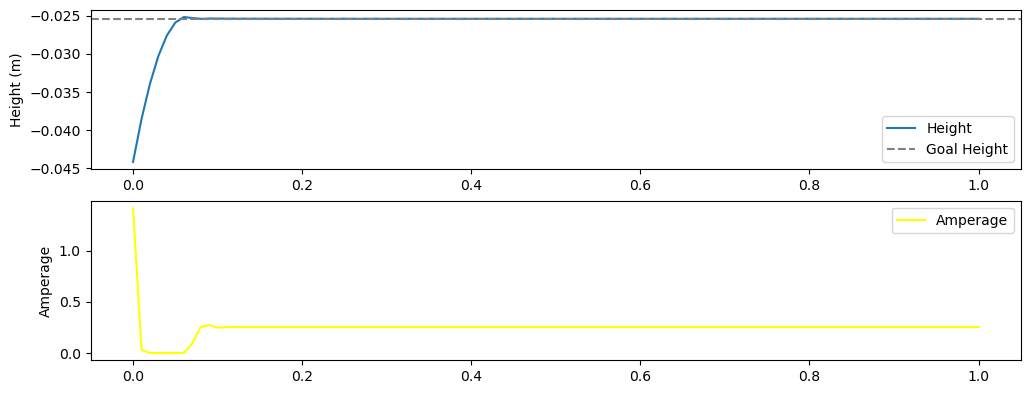

In [33]:
def get_actual_position(y):
  return y #+ np.random.normal(0,0.0001)

def predict_pos_pid(K,y_measured,velocity,y_error_sum,dyde_lag,y_error_lag):

  y_error = Y_GOAL - y_measured
  dyde_raw = (y_error-y_error_lag)/TIME_STEP
  a = .9
  dyde_smooth = a*dyde_raw + (1-a)*dyde_lag
  pid_out = K @ np.array([y_error,y_error_sum,dyde_smooth])
  # PID + feed-forward
  I_ff = np.sqrt(BALL_MASS*abs(GRAVITY)*y_measured**2 / MAGNET_CONSTANT)

  ampsend_raw = amperage_hover + pid_out
  ampsend_clamp = min(max(ampsend_raw,0),AMP_MAX)
  if ampsend_clamp == ampsend_raw: # Clamp the integration term if we have reached max amperage
    y_error_sum += y_error*TIME_STEP
  amperage = ampsend_clamp

  y_error_lag = y_error
  dyde_lag = dyde_smooth

  mag_force = MAGNET_CONSTANT * amperage**2 / y_measured**2
  acceleration = mag_force/BALL_MASS + GRAVITY
  velocity += acceleration * TIME_STEP

  y = y_measured + velocity * TIME_STEP

  return y, amperage, velocity, acceleration, y_error,y_error_sum,dyde_lag,y_error_lag

def run_real_time_mag_lev_pid(K, hist=False):
  np.random.seed(42)
  y_measured = Y_INIT
  amperage = AMP_INIT
  y_error_sum = 0.0
  y_error_lag = Y_GOAL-y_measured
  dyde_lag = 0
  velocity = 0
  tot_energy = 0.0
  t_to_target = None

  history = []
  for time in times:
    y, amperage, velocity, acceleration, y_error,y_error_sum,dyde_lag,y_error_lag = predict_pos_pid(K,y_measured,velocity,y_error_sum,dyde_lag,y_error_lag)
    tot_energy += amperage**2 * TIME_STEP
    y_measured = get_actual_position(y)
    history.append({
          'time': time,
          'height': y_measured,
          'predicted_height': y,
          'velocity': velocity,
          'acceleration': acceleration,
          'y_error': y_error,
          'amperage': amperage,
          'total_energy': tot_energy,
    })

    if t_to_target is None:
        if abs(y_measured - Y_GOAL) < tol:
            t_to_target = time
    if np.isnan(y_measured) or np.isnan(amperage) or np.isnan(tot_energy):
        print("Simulation blew up!")
        return np.inf, np.inf, np.inf, np.inf, np.inf

  df = pd.DataFrame(history)

  post_target_df = df.loc[df['time'] > t_to_target]

  if post_target_df.empty:
      # If no data after target time, assign penalty or a default value
      RMS_error = np.inf # Penalize if the ball only reaches the target at the very end
      norm_err = np.inf
      RMS_acc = 0 # No acceleration after target time if no data exists
      norm_acc = 0
  else:
      RMS_error = np.sqrt(np.mean(post_target_df['y_error']**2))
      norm_err = RMS_error/abs(Y_GOAL)*5

      RMS_acc = np.sqrt(np.mean(post_target_df['acceleration']**2))
      # Check if max acceleration is zero to avoid division by zero
      max_abs_acc = max(abs(post_target_df['acceleration']))
      if max_abs_acc == 0:
          norm_acc = 0
      else:
          norm_acc = RMS_acc/max_abs_acc/10
  tot_pow_cons = max(df['total_energy'])
  norm_pow_cons = tot_pow_cons/POWER_GOAL/100

  if hist:
    plt.figure(figsize=(12,12))
    # 1. Height
    plt.subplot(5, 1, 1)
    plt.plot(df['time'], df['height'], label="Height")
    plt.axhline(Y_GOAL, color='gray', linestyle='--', label="Goal Height")
    plt.ylabel("Height (m)")
    plt.legend()

    # 2. Amperage
    plt.subplot(5, 1, 2)
    plt.plot(df['time'], df['amperage'], label="Amperage", color='yellow')
    plt.ylabel("Amperage")
    plt.legend()
    print(df.head())

    print(f"Time: {t_to_target}")
    

  return t_to_target, norm_err, norm_acc, norm_pow_cons, tot_pow_cons



Kp_bounds = (0, 100)
Ki_bounds = (0, 8)
Kd_bounds = (0, 20)
bounds = [Kp_bounds, Ki_bounds, Kd_bounds]

real_time_cost = partial(cost,fn=run_real_time_mag_lev_pid)

optimized_real_time = differential_evolution(
    real_time_cost, bounds,
    # disp=True,
    maxiter=1000,         # reduce from default 1000
    popsize=10,         # reduce from default 15
    tol=1e-3,           # slightly looser tolerance
    seed=42
)

# print(optimized.x)
print(optimized_real_time.x)
run_real_time_mag_lev_pid(optimized_real_time.x,hist=True)


### 4. Used cascade controller

[ 4.64379888  5.43281855 11.15758684 78.91712386  1.56963264 13.47665635]
   time    height  predicted_height  velocity  acceleration   y_error  \
0  0.00 -0.036093         -0.036093  1.421003    142.100304  0.025400   
1  0.01 -0.023001         -0.023001  1.323003     -9.800000  0.010693   
2  0.02 -0.010104         -0.010104  1.225003     -9.800000 -0.002399   
3  0.03  0.002689          0.002689  1.127003     -9.800000 -0.015296   
4  0.04  0.012745          0.012745  1.029003     -9.800000 -0.028089   

   amperage  total_energy  
0       2.0          0.04  
1       0.0          0.04  
2       0.0          0.04  
3       0.0          0.04  
4       0.0          0.04  


(None, inf, 0, 0.0008, 0.08)

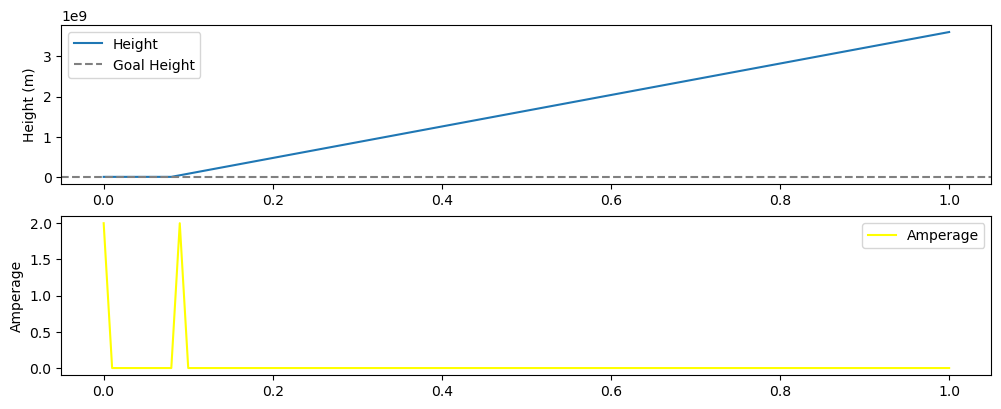

In [ ]:
# K_pos = optimal_K_pred
# K_vel = np.array([0,0,0])


def get_actual_position(y):
  return y + np.random.normal(0,0.001)

def predict_pos_pid(K_all, y_measured, y_error_lag, y_error_sum, dyde_lag,v, v_error_lag, v_error_sum, dvde_lag):
  Kp_pos, Ki_pos, Kd_pos, Kp_vel, Ki_vel, Kd_vel = K_all

  # outer loop: position -> velocity setpoint
  y_error = Y_GOAL - y_measured
  y_error_sum += y_error*TIME_STEP
  dyde_raw = (y_error-y_error_lag)/TIME_STEP
  a = 1
  dyde_smooth = a*dyde_raw + (1-a)*dyde_lag
  v_setpoint = np.array([Kp_pos, Ki_pos, Kd_pos]) @ np.array([y_error,y_error_sum,dyde_smooth])
  y_error_lag = y_error
  
  # inner loop: velocity -> current
  v_error = v_setpoint - v
  dvde_raw = (v_error-v_error_lag)/TIME_STEP
  b = .2
  dvde_smooth = b*dvde_raw + (1-b)*dvde_lag
  pid_vel = np.array([Kp_vel, Ki_vel, Kd_vel]) @ np.array([v_error,v_error_sum,dvde_smooth])


  I_ff = np.sqrt(BALL_MASS*abs(GRAVITY)*y_measured**2 / MAGNET_CONSTANT)

  ampsend_raw = I_ff + pid_vel
  ampsend_clamp = min(max(ampsend_raw,0),AMP_MAX)

  # Back calculating the integral term
  if ampsend_raw == ampsend_clamp:
    v_error_sum += v_error * TIME_STEP
  v_error_lag = v_error
  
  dyde_lag = dyde_smooth
  dvde_lag = dvde_smooth

  mag_force = MAGNET_CONSTANT * ampsend_clamp**2 / min(y_measured,-1e-6)**2
  acceleration = mag_force/BALL_MASS + GRAVITY
  v += acceleration * TIME_STEP
  y = y_measured + v * TIME_STEP

  return (y, y_error, y_error_lag, y_error_sum, dyde_lag,
          v, v_error_lag, v_error_sum, dvde_lag,
          ampsend_clamp, acceleration)

def run_real_time_mag_lev_cascade(K, hist=False):
  np.random.seed(42)
  assert len(K) == 6, "expected 6 gains (3 pos + 3 vel)"
  y = Y_INIT
  amperage = AMP_INIT
  y_error_sum = 0.0
  y_error_lag = Y_GOAL-y
  dyde_lag = 0
  dvde_lag = 0
  v = V_INIT
  v_error_sum = 0.0
  v_error_lag = 0

  tot_energy = 0.0
  t_to_target = None

  history = []
  for time in times:
    (y, y_error, y_error_lag, y_error_sum, dyde_lag,
     v, v_error_lag, v_error_sum, dvde_lag,
     amperage, acceleration) = predict_pos_pid(K, y, y_error_lag, y_error_sum, dyde_lag,v, v_error_lag, v_error_sum, dvde_lag)
    tot_energy += amperage**2 * TIME_STEP
    y_measured = get_actual_position(y)
    y = y_measured
    history.append({
          'time': time,
          'height': y_measured,
          'predicted_height': y,
          'velocity': v,
          'acceleration': acceleration,
          'y_error': y_error,
          'amperage': amperage,
          'total_energy': tot_energy,
    })

    if t_to_target is None:
        if abs(y_measured - Y_GOAL) < tol:
            t_to_target = time
    if np.isnan(y_measured) or np.isnan(amperage) or np.isnan(tot_energy):
        print("Simulation blew up!")
        return np.inf, np.inf, np.inf, np.inf, np.inf

  df = pd.DataFrame(history)

  post_target_df = df.loc[df['time'] > t_to_target]

  if post_target_df.empty:
      # If no data after target time, assign penalty or a default value
      RMS_error = np.inf # Penalize if the ball only reaches the target at the very end
      norm_err = np.inf
      RMS_acc = 0 # No acceleration after target time if no data exists
      norm_acc = 0
  else:
      RMS_error = np.sqrt(np.mean(post_target_df['y_error']**2))
      norm_err = RMS_error/abs(Y_GOAL)*5

      RMS_acc = np.sqrt(np.mean(post_target_df['acceleration']**2))
      # Check if max acceleration is zero to avoid division by zero
      max_abs_acc = max(abs(post_target_df['acceleration']))
      if max_abs_acc == 0:
          norm_acc = 0
      else:
          norm_acc = RMS_acc/max_abs_acc/10
  tot_pow_cons = max(df['total_energy'])
  norm_pow_cons = tot_pow_cons/POWER_GOAL/100

  if hist:
    plt.figure(figsize=(12,12))
    # 1. Height
    plt.subplot(5, 1, 1)
    plt.plot(df['time'], df['height'], label="Height")
    plt.axhline(Y_GOAL, color='gray', linestyle='--', label="Goal Height")
    plt.ylabel("Height (m)")
    plt.legend()

    # 2. Amperage
    plt.subplot(5, 1, 2)
    plt.plot(df['time'], df['amperage'], label="Amperage", color='yellow')
    plt.ylabel("Amperage")
    plt.legend()
    print(df.head())

  return t_to_target, norm_err, norm_acc, norm_pow_cons, tot_pow_cons



Kp_pos_bounds = (0, 100)
Ki_pos_bounds = (0, 8)
Kd_pos_bounds = (0, 20)
Kp_vel_bounds = (0, 100)
Ki_vel_bounds = (0, 8)
Kd_vel_bounds = (0, 20)

bounds = [Kp_pos_bounds, Ki_pos_bounds, Kd_pos_bounds,Kp_vel_bounds, Ki_vel_bounds, Kd_vel_bounds]


real_time_cost = partial(cost,fn=run_real_time_mag_lev_cascade)

optimized_real_time = differential_evolution(
    real_time_cost, bounds,
    # disp=True,
    maxiter=1000,         # reduce from default 1000
    popsize=10,         # reduce from default 15
    tol=1e-3,           # slightly looser tolerance
    seed=42
)

print(optimized_real_time.x)
run_real_time_mag_lev_cascade(optimized_real_time.x,hist=True)

In [ ]:
# lqr and total energy control